In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
import torch
from matplotlib import pylab as P
import matplotlib.pyplot as plt
import os
from PIL import Image
from vin_big_dataset import Vin_big_dataset
from transform_vin_big import vin_big_transform
# from model_global import global_model
# from model_local import local_model
import matplotlib.patches as ptc
from utils import read_xray
from model_seg import seg_model, lung_seg
from saliency_map import xrai_masks, ShowHeatMap
import torch
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import cv2
import glob
import albumentations as A
import torch.nn as nn
from tqdm.notebook import tqdm

In [40]:
def plot_bb(path2img, train_csv, image_name):
    img = read_xray(path2img)
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap = 'gray')

    for i in range(0,len(train_csv[train_csv['image_id']==image_name])):
        rect = ptc.Rectangle((train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                              train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i]), 
                             train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_max[i]-train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                             train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_max[i]-train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i], 
                             linewidth = 2, edgecolor = '#e7298a', facecolor = 'none')
        ax.add_patch(rect)
        ax.annotate(train_csv[train_csv['image_id']==image_name].reset_index(drop = True).class_name[i],
                    (train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                    train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i] - 24),  )
        
    ax.imshow(img, cmap = 'gray')

cols = ['#e41a1c', '#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#000000', '#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#e7098a', '#e7298a', '#a7298a','#e2208a','#e7298a','#f7298a','#e4298a', '#f4298a']

In [3]:
labels_csv = {'train': "/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/weekly_supervised/new_image_labels_train.csv",
             'test': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_test.csv"
             }
labels_csv_bb = {'train': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_train.csv",
             'test': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_test.csv"
             }
data_dir = {'train': "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/train/",
           'test': "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/test/"}

global_labels = ['COPD', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
local_labels = ['Aortic enlargement', 'Atelectasis',
       'Calcification', 'Cardiomegaly', 'Clavicle fracture', 'Consolidation',
       'Edema', 'Emphysema', 'Enlarged PA', 'ILD', 'Infiltration',
       'Lung Opacity', 'Lung cavity', 'Lung cyst', 'Mediastinal shift',
       'Nodule/Mass', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis', 'Rib fracture', 'Other lesion', 'No finding']

In [5]:
train_label = pd.read_csv(labels_csv['train'])
test_label = pd.read_csv(labels_csv['test'])
rnd_img_test = np.random.choice(os.listdir(data_dir['test']), size = 4)
rnd_img_train = np.random.choice(os.listdir(data_dir['train']), size = 4)
train_label_bb = pd.read_csv(labels_csv_bb['train'])
test_label_bb = pd.read_csv(labels_csv_bb['test'])

In [4]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p = 0.2),
    A.RandomRotate90(p=0.1),
    A.Rotate((-30,30), p = 0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.3),
    A.CLAHE(p=0.5),
    A.RandomBrightnessContrast(p=5)
])
test_transforms = A.Compose([
    A.Rotate(0, p = 1)
        ])

In [26]:
norm = A.Normalize()

In [6]:
# local_model = local_model("/scratch/scratch6/akansh12/DeepEXrays/local_label/0.891597_.pth")
seg_model = seg_model('/scratch/scratch6/akansh12/DeepEXrays/lung_seg_model/0.977697_.pth')

In [7]:
class Vin_big_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transforms, data_type, selec_radio, radio_id = None, label_type = None):
        if label_type == 'global':
            global_labels = ['COPD', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
        if label_type == 'local':
            global_labels = ['Aortic enlargement', 'Atelectasis',
       'Calcification', 'Cardiomegaly', 'Clavicle fracture', 'Consolidation',
       'Edema', 'Emphysema', 'Enlarged PA', 'ILD', 'Infiltration',
       'Lung Opacity', 'Lung cavity', 'Lung cyst', 'Mediastinal shift',
       'Nodule/Mass', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis', 'Rib fracture', 'Other lesion', 'No finding']
        
        if data_type == 'train':
            label_df = pd.read_csv(label_loc)
            if selec_radio == 'rand_one':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames = np.unique(label_df.index.values).tolist()
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
                self.labels = []
                for i in (filenames):
                    self.labels.append(label_df[global_labels].loc[i].values.tolist()[np.random.choice([0,1,2])])
                self.labels = torch.tensor(self.labels)
            if selec_radio == 'agree_two':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames_temp = np.unique(label_df.index.values).tolist()
                self.labels = []
                filenames = []
                for i in filenames_temp:
                    a,b = np.unique(label_df.loc[i][global_labels].values, axis = 0, return_counts=True)
                    if b[0] >= 2:/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/normal_vs_abnormal/train_normal_vs_abnormal.csv
                        filenames.append(i)
                        self.labels.append(a[0])
                self.labels = torch.tensor(self.labels)
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
            if selec_radio == 'agree_three':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames_temp = np.unique(label_df.index.values).tolist()
                self.labels = []
                filenames = []
                for i in filenames_temp:
                    a,b = np.unique(label_df.loc[i][global_labels].values, axis = 0, return_counts=True)
                    if b[0] == 3:
                        filenames.append(i)
                        self.labels.append(a[0])
                self.labels = torch.tensor(self.labels)
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
            if selec_radio == 'radio_per_epoch':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames = np.unique(label_df.index.values).tolist()
                self.labels = []
                for i in filenames:
                    self.labels.append(label_df.loc[i][global_labels].values[radio_id].tolist())
                self.labels = torch.tensor(self.labels)
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
            if selec_radio == 'all': 
#                 label_df['labels'] = label_df['image_id'] +'_'+ label_df['rad_id']
                label_df.set_index("image_id", inplace = True)
                filenames = label_df.index.values.tolist()
            
                self.full_filenames = [os.path.join(image_loc,i+'.png') for i in filenames]
                self.labels = []
                for i in tqdm(filenames):
                    self.labels.append(label_df[global_labels].loc[i].values.tolist())         
                self.labels = torch.tensor(self.labels)
                
        if data_type == 'test':                     
            filenames = os.listdir(image_loc)
            self.full_filenames = [os.path.join(image_loc, i) for i in filenames]
            label_df = pd.read_csv(label_loc)
            label_df.set_index("image_id", inplace = True)
            self.labels = [label_df[global_labels].loc[filename[:-4]].values for filename in filenames]
            
        self.transforms = transforms
        self.norm_transform = A.Normalize()
#         self.data_type = data_type
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        augmented = self.transforms(image=np.array(image))
        img = augmented['image']
        img = self.norm_transform(image=img)["image"]
        
        return torch.tensor(img), self.labels[idx]

In [8]:
train_data = Vin_big_dataset(image_loc = data_dir['train'],
                          label_loc = labels_csv['train'],
                          transforms = train_transforms,
                          data_type = 'train', selec_radio = 'all', label_type = 'local')

test_data = Vin_big_dataset(image_loc = data_dir['test'],
                          label_loc = labels_csv['test'],
                          transforms = test_transforms,
                          data_type = 'test', selec_radio = None, label_type = 'local')

trainloader = DataLoader(train_data,batch_size = 4,shuffle = False)
testloader = DataLoader(test_data,batch_size = 8,shuffle = False)

  0%|          | 0/15000 [00:00<?, ?it/s]

#### Local Model

In [9]:
import timm
from collections import OrderedDict
model = timm.create_model('efficientnet_b6', pretrained=False)
model.load_state_dict(torch.load("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/tf_efficientnet_b6_aa-80ba17e4.pth"))
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(2304,23)),
    ('out', nn.Sigmoid()),
]))

state_dict = torch.load("/scratch/scratch6/akansh12/DeepEXrays/local_label/efficient-net/local_label.pth", map_location=torch.device('cpu'))['state_dict']
for keyA, keyB in zip(state_dict, model.state_dict()):
        state_dict = OrderedDict((keyB if k == keyA else k, v) for k, v in state_dict.items())
model.load_state_dict(state_dict)
    



<All keys matched successfully>

### Example 1

In [10]:
path2img = os.path.join(data_dir['train'] + '0005e8e3701dfb1dd93d53e2ff537b6e' + '.png')

In [11]:
img = Image.open(path2img)

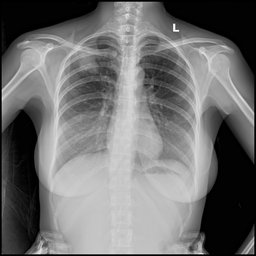

In [12]:
img

In [14]:
m = torch.unsqueeze(torch.tensor(norm(image = test_transforms(image = np.array(Image.open(path2img)))['image'])['image']), dim = 0).permute(0,3,1,2).float()

In [15]:
m = torch.unsqueeze(m, dim = 0)

In [16]:
m.shape

torch.Size([1, 256, 256, 3])

In [17]:
m = m.permute(0,3,1,2).float()

In [18]:
with torch.no_grad():
    model.eval()
    out = model(m) 

In [ ]:
a,b = lung_seg(path2img, model = seg_model, back = True)

In [ ]:
plt.imshow(a)

In [ ]:
plt.imshow(b)

In [ ]:
attributions = xrai_masks(path2img, local_model)

In [ ]:
plt.imshow(attributions, cmap = 'inferno')

In [ ]:
mask = attributions > np.percentile(attributions, 95)
plt.imshow(mask)

In [ ]:
plot_bb('/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/train/0005e8e3701dfb1dd93d53e2ff537b6e.dicom', train_label_bb, '0005e8e3701dfb1dd93d53e2ff537b6e')

### Example 2

In [28]:
path2img = os.path.join(data_dir['train'] + '00ad02393a5d0bd1e0dcf3196433499f' + '.png')

In [30]:
with torch.no_grad():
    model.eval()
    out = model(torch.unsqueeze(torch.tensor(norm(image = test_transforms(image = np.array(Image.open(path2img)))['image'])['image']), dim = 0).permute(0,3,1,2).float()) 

In [31]:
local_labels[np.argmax(out.numpy() > 0.5)]

'No finding'

In [32]:
a,b = lung_seg(path2img, model = seg_model, back = True)

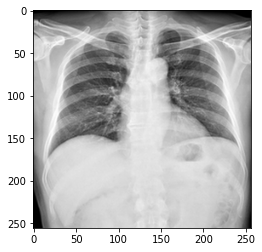

In [33]:
plt.imshow(a)

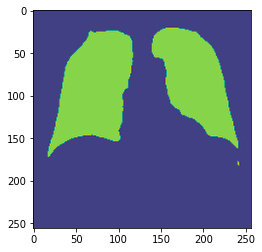

In [34]:
plt.imshow(b)

In [36]:
attributions = xrai_masks(path2img, model)

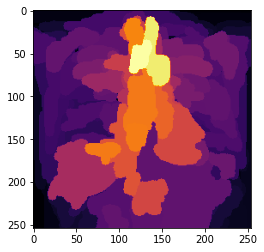

In [37]:
plt.imshow(attributions, cmap = 'inferno')

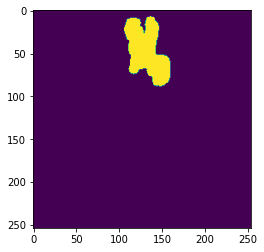

In [38]:
mask = attributions > np.percentile(attributions, 95)
plt.imshow(mask)

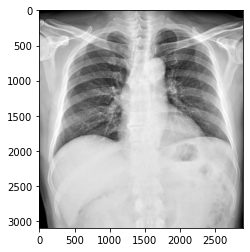

In [41]:
plot_bb('/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/train/00ad02393a5d0bd1e0dcf3196433499f.dicom', train_label_bb, '00ad02393a5d0bd1e0dcf3196433499f')

#### Test

In [44]:
path2img = os.path.join(data_dir['test'] + 'e0dc2e79105ad93532484e956ef8a71a' + '.png')

In [46]:
with torch.no_grad():
    model.eval()
    out = model(torch.unsqueeze(torch.tensor(norm(image = test_transforms(image = np.array(Image.open(path2img)))['image'])['image']), dim = 0).permute(0,3,1,2).float()) 

In [47]:
local_labels[np.argmax(out.numpy() > 0.5)]

'No finding'

In [48]:
a,b = lung_seg(path2img, model = seg_model, back = True)

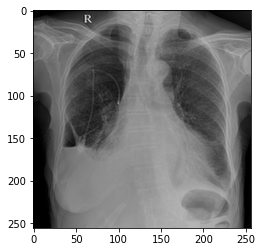

In [49]:
plt.imshow(a)

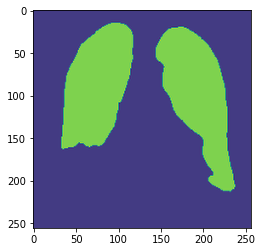

In [50]:
plt.imshow(b)

In [53]:
attributions = xrai_masks(path2img, model)

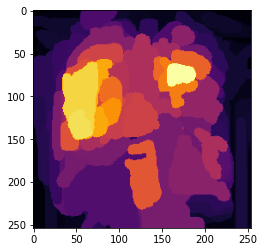

In [54]:
plt.imshow(attributions, cmap = 'inferno')

In [55]:
mask = attributions > np.percentile(attributions, 90)


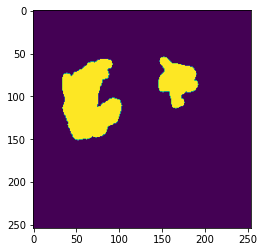

In [56]:
plt.imshow(mask)

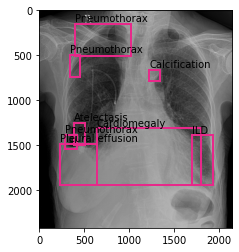

In [57]:
plot_bb('/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/test/e0dc2e79105ad93532484e956ef8a71a.dicom', test_label_bb, 'e0dc2e79105ad93532484e956ef8a71a')

In [58]:
path2img = os.path.join(data_dir['test'] + 'e0dc2e79105ad93532484e956ef8a71a' + '.png')

In [66]:
 % 10 == 0

False